In [112]:
using Distributions
using StatsPlots
using LaTeXStrings
using CSV
using DataFrames
using StatisticalRethinking
using Logging
using Turing
using MCMCChains

# setting default attributes for plots
default(labels=false)

# 4.1 Why normal distributions are normal

Code 4.1

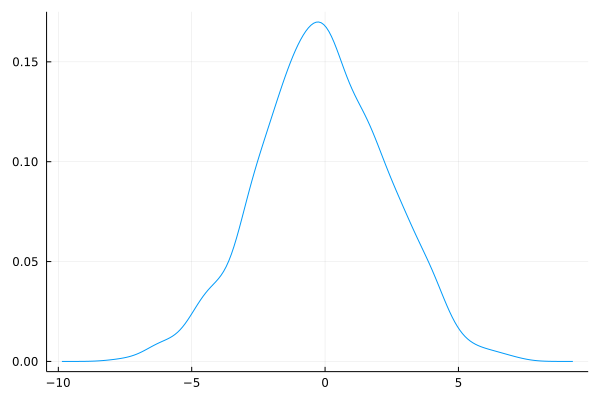

In [9]:
n = rand(Uniform(-1, 1), 1000, 16);
pos = sum.(eachrow(n));
density(pos)

Code 4.2

In [11]:
prod(1 .+ rand(Uniform(0, .1), 12))

2.1179991123749504

Code 4.3

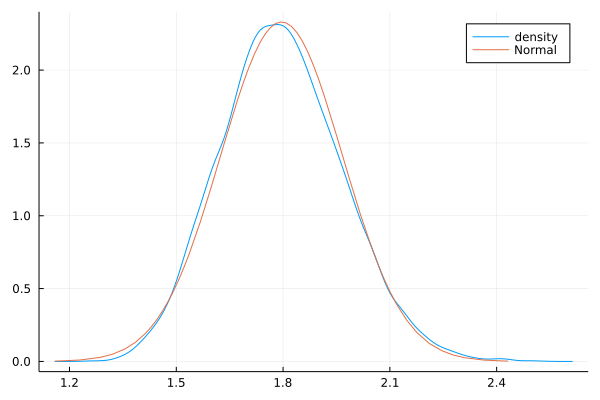

In [12]:
u = Uniform(0, .1)
growth = prod.(eachrow(1 .+ rand(u, 10000, 12)));

density(growth; label="density")
# overlay normal distribution
μ = mean(growth)
σ = std(growth)
plot!(Normal(μ, σ); label="Normal")

Code 4.4

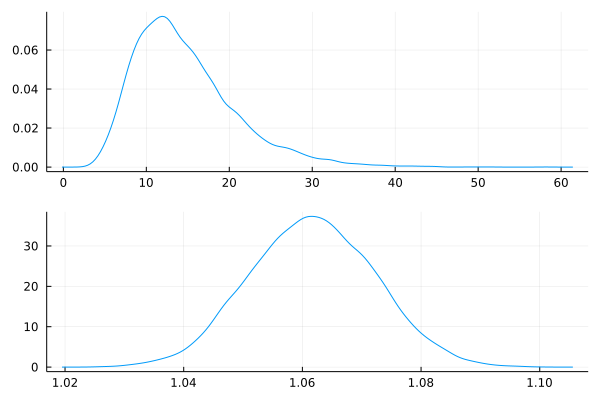

In [25]:
big = prod.(eachrow(1 .+ rand(Uniform(0, 0.5), 10000, 12)));
small = prod.(eachrow(1 .+ rand(Uniform(0, 0.01), 10000, 12)));
density([big, small]; layout=(2, 1))

Code 4.5

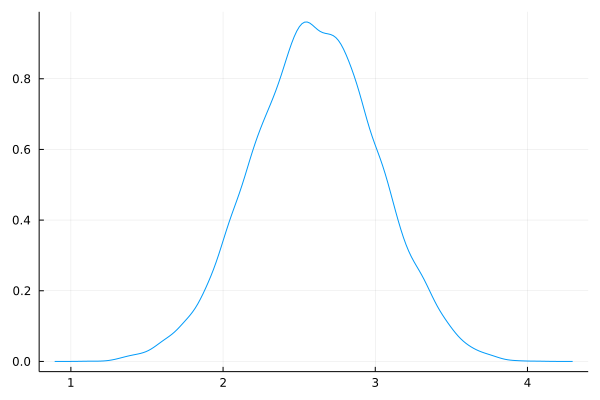

In [28]:
density(log.(big))

# 4.2 A language for describing models

Code 4.6

In [29]:
w = 6
n = 9
p_grid = range(0, 1; length=100)
bin_dens = [pdf(Binomial(n, p), w) for p in p_grid]
uni_dens = [pdf(Uniform(0, 1), p) for p in p_grid];
posterior = bin_dens .* uni_dens
posterior /= sum(posterior);

# 4.3 Gaussian model of height

Code 4.7

In [31]:
d = DataFrame(CSV.File("data/Howell1.csv"));

Code 4.8

In [32]:
describe(d)

4×7 DataFrame
 Row │ variable  mean        min       median    max       nmissing  eltype   
     │ Symbol    Float64     Real      Float64   Real      Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ height    138.264     53.975    148.59    179.07           0  Float64
   2 │ weight     35.6106     4.25242   40.0578   62.9926         0  Float64
   3 │ age        29.3444     0.0       27.0      88.0            0  Float64
   4 │ male        0.472426   0          0.0       1              0  Int64

Code 4.9

In [35]:
precis(d)

┌────────┬────────────────────────────────────────────────────────────┐
│  param │    mean      std     5.5%      50%    94.5%      histogram │
├────────┼────────────────────────────────────────────────────────────┤
│ height │ 138.264  27.6024  81.1086   148.59  165.735  ▁▁▁▂▂▂▂▂▂██▆▁ │
│ weight │ 35.6106  14.7192   9.3607  40.0578  54.5029  ▁▃▄▄▃▂▃▆██▅▃▁ │
│    age │ 29.3444  20.7469      1.0     27.0   66.135      █▆▆▆▆▃▃▁▁ │
│   male │  0.4724   0.4997      0.0      0.0      1.0    █▁▁▁▁▁▁▁▁▁█ │
└────────┴────────────────────────────────────────────────────────────┘


Code 4.10

In [38]:
d.height

544-element Array{Float64,1}:
 151.765
 139.7
 136.525
 156.845
 145.415
 163.83
 149.225
 168.91
 147.955
 165.1
 154.305
 151.13
 144.78
   ⋮
 156.21
 152.4
 162.56
 114.935
  67.945
 142.875
  76.835
 145.415
 162.56
 156.21
  71.12
 158.75

Code 4.11

In [50]:
d2 = d[d.age .>= 18,:];

Code 4.12

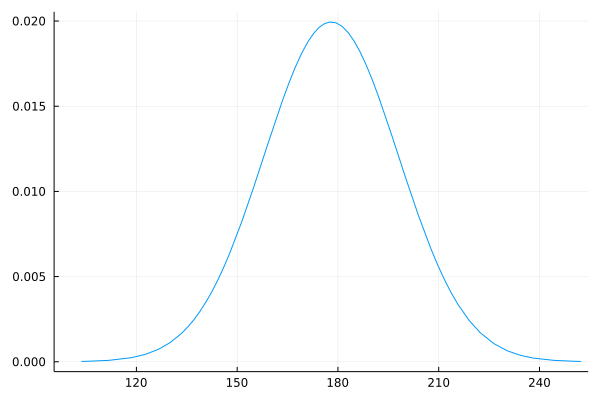

In [51]:
plot(Normal(178, 20); xlim=(100, 250))

Code 4.13

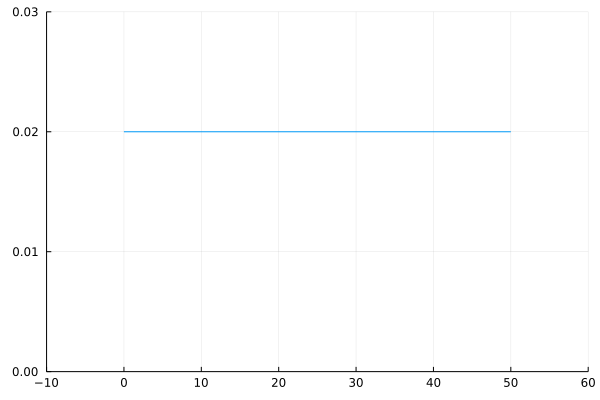

In [66]:
plot(Uniform(0, 50), xlim=(-10, 60), ylim=(0, 0.03))

Code 4.14

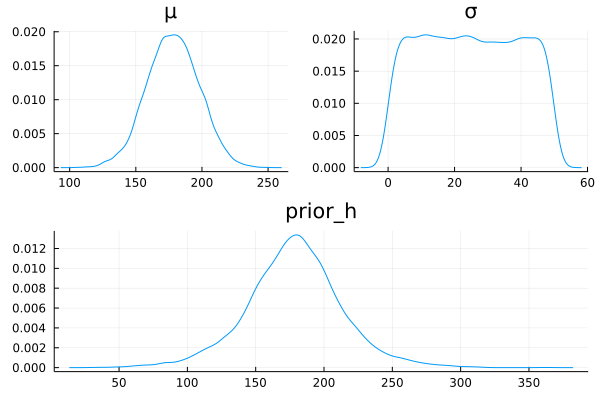

In [61]:
size = 10_000
sample_μ = rand(Normal(178, 20), size)
sample_σ = rand(Uniform(0, 50), size);
prior_h = [rand(Normal(μ, σ)) for (μ, σ) in zip(sample_μ, sample_σ)];

p1 = density(sample_μ; title="μ")
p2 = density(sample_σ; title="σ")
p3 = density(prior_h; title="prior_h")

plot(p1, p2, p3, layout=@layout [a b; c])

Code 4.15

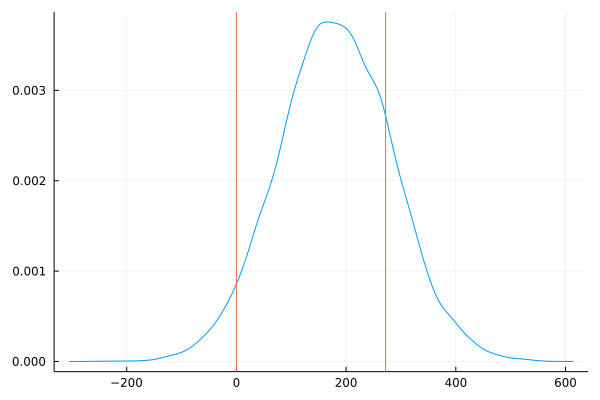

In [63]:
sample_μ = rand(Normal(178, 100), size)
prior_h = [rand(Normal(μ, σ)) for (μ, σ) in zip(sample_μ, sample_σ)];

density(prior_h)
vline!([0, 272])

Code 4.16

In [72]:
μ_list = range(150, 160; length=100)
σ_list = range(7, 9; length=100)

log_likelihood = [
    sum(logpdf(Normal(μ, σ), d2.height))
    for μ ∈ μ_list, σ ∈ σ_list
]
log_prod = log_likelihood .+ [
    logpdf(Normal(178, 20), μ) + logpdf(Uniform(0, 50), σ)
    for μ ∈ μ_list, σ ∈ σ_list
];

max_prod = maximum(log_prod)
prob = @. exp(log_prod - max_prod);

Code 4.17

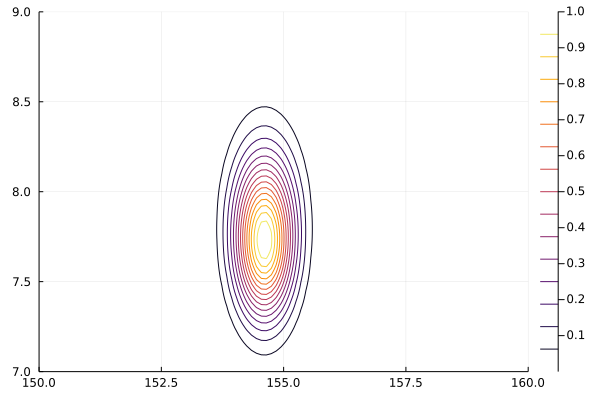

In [73]:
# note the transposition, that's due to Julia matrix order
contour(μ_list, σ_list, prob')

Code 4.18

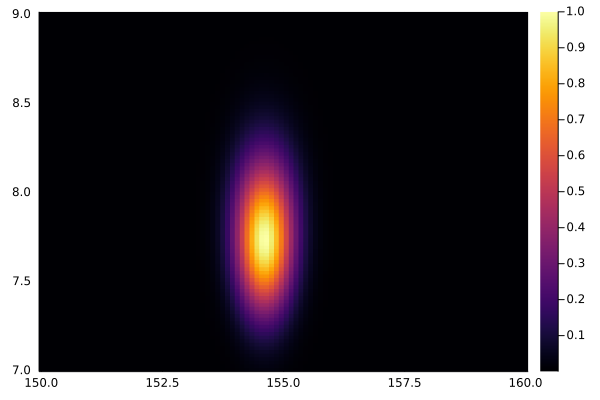

In [74]:
heatmap(μ_list, σ_list, prob')

Code 4.19

In [75]:
indices = collect(Iterators.product(1:length(μ_list), 1:length(σ_list)));
sample_idx = wsample(vec(indices), vec(prob), 10_000; replace=true)
sample_μ = μ_list[first.(sample_idx)]
sample_σ = σ_list[last.(sample_idx)];

Code 4.20

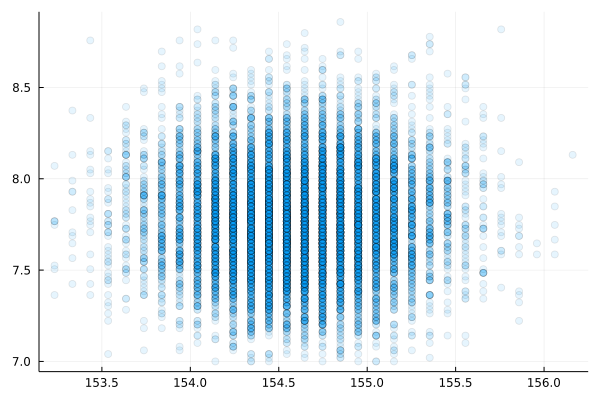

In [76]:
scatter(sample_μ, sample_σ; alpha=0.1)

Code 4.21

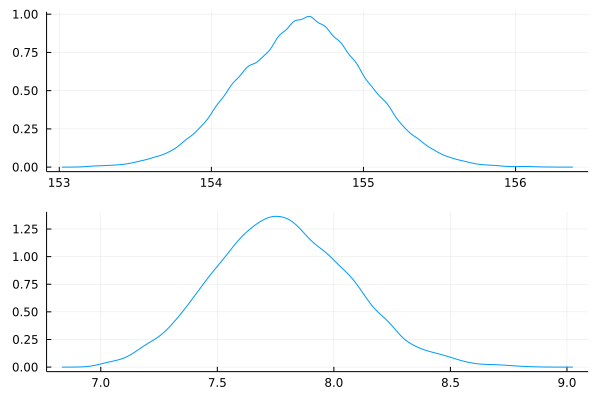

In [82]:
p1 = density(sample_μ)
p2 = density(sample_σ)
plot(p1, p2, layout=(2,1))

Code 4.22

In [84]:
println(hpdi(sample_μ, alpha=0.11))
println(hpdi(sample_σ, alpha=0.11))

[153.83838383838383, 155.15151515151516]
[7.3232323232323235, 8.232323232323232]


Code 4.23

In [97]:
d3 = sample(d2.height, 20);

Code 4.24

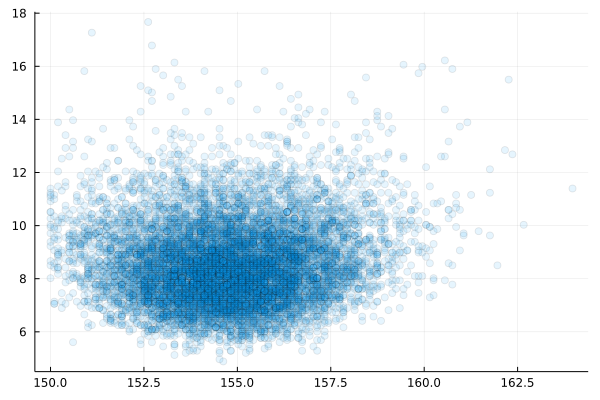

In [99]:
μ_list = range(150, 170; length=200)
σ_list = range(4, 20; length=200)

log_likelihood = [
    sum(logpdf(Normal(μ, σ), d3))
    for μ ∈ μ_list, σ ∈ σ_list
]
log_prod = log_likelihood .+ [
    logpdf(Normal(178, 20), μ) + logpdf(Uniform(0, 50), σ)
    for μ ∈ μ_list, σ ∈ σ_list
]

max_prod = maximum(log_prod)
prob2 = @. exp(log_prod - max_prod)

indices = collect(Iterators.product(1:length(μ_list), 1:length(σ_list)));
sample2_idx = wsample(vec(indices), vec(prob2), 10_000; replace=true)
sample2_μ = μ_list[first.(sample2_idx)]
sample2_σ = σ_list[last.(sample2_idx)]

scatter(sample2_μ, sample2_σ; alpha=0.1)

Code 4.25

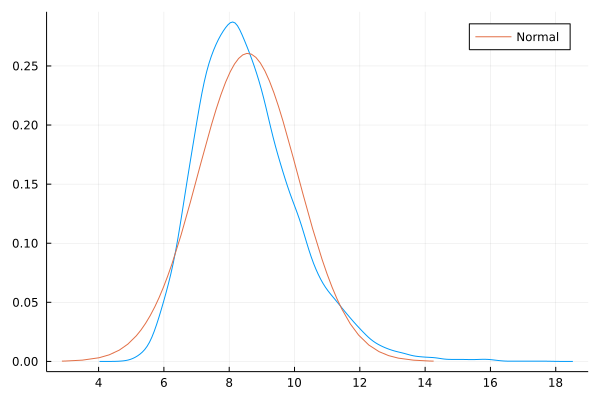

In [100]:
density(sample2_σ)
μ = mean(sample2_σ)
σ = std(sample2_σ)
plot!(Normal(μ, σ); label="Normal")

Code 4.26

In [101]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:];

Code 4.27

In [103]:
@model function model_height(height)
    μ ~ Normal(178, 20)
    σ ~ Uniform(0, 50)
    height ~ Normal(μ, σ)
end

model_height (generic function with 1 method)

Code 4.28

In [142]:
Logging.disable_logging(Logging.Warn)
m4_1 = sample(model_height(d2.height), NUTS(), 1000)
print(MCMCChains.header(m4_1))

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.05 seconds
Compute duration  = 0.05 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size


Code 4.29

In [128]:
display.(describe(m4_1; q=[0.055, 0.945]));

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           μ   177.8650    0.1013     0.0032    0.0020   902.3263    0.9997    ⋯
           σ    24.6208    0.9946     0.0315    0.0342   896.8648    1.0042    ⋯
                                                                1 column omitted


Quantiles
  parameters       5.5%      94.5% 
      Symbol    Float64    Float64 

           μ   177.7061   178.0253
           σ    23.0656    26.3055


Code 4.30

In [129]:
init_vals = [mean(d2.height), std(d2.height)]
chain = sample(model_height(d2.height), NUTS(), 1000, init_theta=init_vals)

Chains MCMC chain (1000×14×1 Array{Float64,3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.37 seconds
Compute duration  = 0.37 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           μ   177.8673    0.0996     0.0031    0.0025   990.7283    1.0015    ⋯
           σ    24.6238    0.9273     0.0293    0.0354   885.9011    1.0011    ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

  

Code 4.31

In [130]:
@model function model_height(height)
    μ ~ Normal(178, 0.1)
    σ ~ Uniform(0, 50)
    height ~ Normal(μ, σ)
end

m4_2 = sample(model_height(d2.height), NUTS(), 1000)
display.(describe(m4_2; q=[0.055, 0.945]));

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           μ   177.8656    0.1029     0.0033    0.0029   1110.4323    0.9996   ⋯
           σ    24.6190    0.8962     0.0283    0.0176   1036.0775    0.9993   ⋯
                                                                1 column omitted


Quantiles
  parameters       5.5%      94.5% 
      Symbol    Float64    Float64 

           μ   177.7010   178.0287
           σ    23.2102    26.0682


Code 4.32

In [144]:
cov(hcat(m4_1[:μ], m4_1[:σ]))

2×2 Array{Float64,2}:
  0.0107024   -0.00361581
 -0.00361581   0.907887

Code 4.33

In [143]:
c = cov(hcat(m4_1[:μ], m4_1[:σ]))
cov2cor(c, diag(c))

2×2 Array{Float64,2}:
  1.0       -0.372127
 -0.372127   1.0

Code 4.34

In [151]:
# resetrange is needed due to bug in MCMCChains: https://github.com/TuringLang/MCMCChains.jl/issues/324
# once it will be fixed, direct sampling from the chain will be possible
samp_chain = sample(resetrange(m4_1), 10_000)
samp_df = DataFrame(samp_chain)
first(samp_df, 5)

5×2 DataFrame
 Row │ μ        σ       
     │ Float64  Float64 
─────┼──────────────────
   1 │ 177.874  24.8879
   2 │ 177.816  24.8238
   3 │ 177.874  23.9438
   4 │ 177.899  24.8332
   5 │ 177.844  26.2534

Code 4.35

In [152]:
precis(samp_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     μ │ 177.873   0.103  177.712  177.875  178.037  ▁▁▂▄▆███▅▄▂▁▁ │
│     σ │ 24.6001  0.9404    23.11   24.596   26.117   ▁▂▄▆▇█▇▄▂▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 4.36

In [153]:
data = hcat(m4_1[:μ], m4_1[:σ])
μ = mean(data, dims=1)
σ = cov(data)
mvn = MvNormal(vec(μ), σ)
post = rand(mvn, 10_000);
print(mvn)

FullNormal(
dim: 2
μ: [177.87131625043492, 24.617932463121125]
Σ: [0.010702410407658635 -0.0036158071343245024; -0.0036158071343245024 0.9078872384775294]
)


# 4.4 Linear predictions

Code 4.37

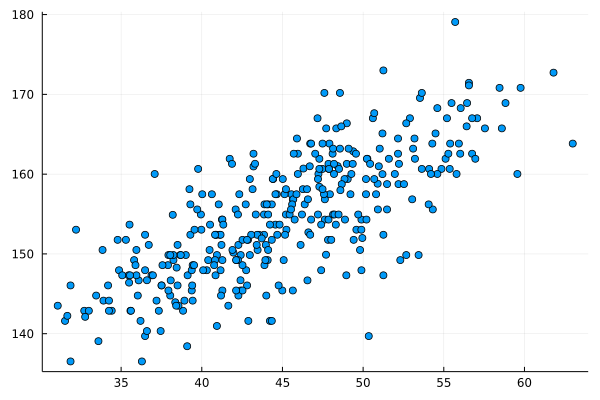

In [161]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:];
# fancy way of doing scatter(d2.weight, d2.height)
@df d2 scatter(:weight, :height)

Code 4.38

In [163]:
Random.seed!(2971)
N = 100
a = rand(Normal(178, 20), N)
b = rand(Normal(0, 10), N);

Code 4.39

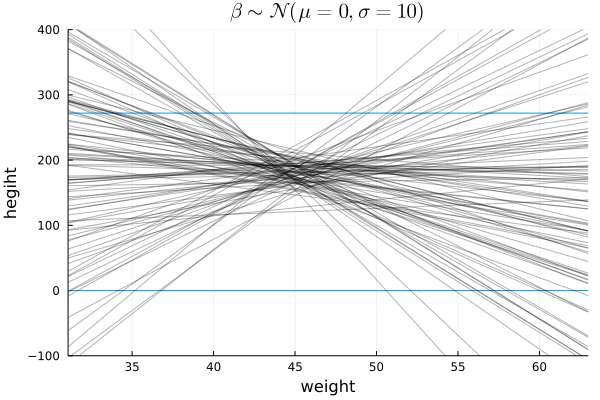

In [166]:
p = hline([0, 272]; ylims=(-100, 400), xlabel="weight", ylabel="hegiht")
title!(L"\beta \sim \mathcal{N}(\mu=0,\sigma=10)")

x_mean = mean(d2.weight)
xlims = extrema(d2.weight)  # getting min and max in one pass

for (α, β) ∈ zip(a, b)
    plot!(x -> α + β * (x - x_mean); xlims=xlims, c=:black, alpha=0.3)
end
display(p)

Code 4.40

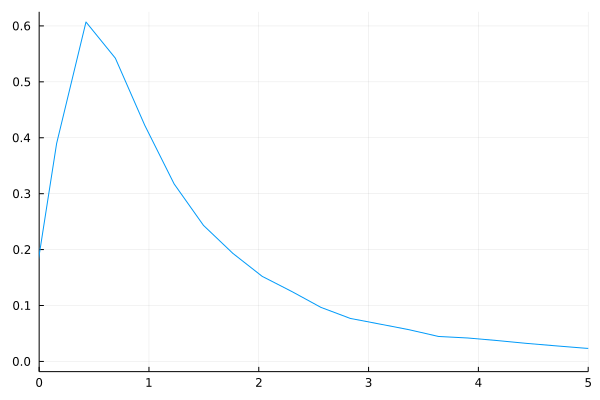

In [169]:
b = rand(LogNormal(0, 1), 10_000)
density(b, xlims=(0, 5), bandwidth=0.1)

Code 4.41

In [170]:
Random.seed!(2971)
N = 100
a = rand(Normal(178, 20), N)
b = rand(LogNormal(0, 1), N);

Code 4.42

In [216]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:]
xbar = mean(d2.weight)

@model function height_regr_model(height, weight)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    μ = @. a + b * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3 = sample(height_regr_model(d2.height, d2.weight), NUTS(), 1000)
m4_3 = resetrange(m4_3);

Code 4.43

In [217]:
@model function height_regr_model_exp(height, weight)
    a ~ Normal(178, 20)
    log_b ~ Normal(0, 1)
    μ = @. a + exp(log_b) * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3b = sample(height_regr_model_exp(d2.height, d2.weight), NUTS(), 1000);

Code 4.44

In [218]:
m4_3_df = DataFrame(m4_3)
precis(m4_3_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%    94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ 154.595  0.2779  154.143   154.6  155.039      ▁▁▂▅██▅▂▁▁ │
│     b │  0.9018  0.0413   0.8345  0.9037   0.9647   ▁▁▂▄▅▇█▆▅▂▁▁▁ │
│     σ │   5.105  0.1872   4.8187  5.1017   5.4104  ▁▁▂▄▇██▆▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 4.45

In [219]:
round.(cov(Matrix(m4_3_df)), digits=3)

3×3 Array{Float64,2}:
  0.077  -0.0    -0.005
 -0.0     0.002   0.0
 -0.005   0.0     0.035

Code 4.46

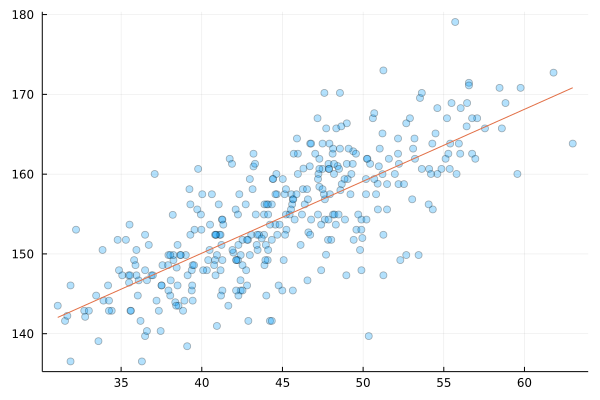

In [220]:
p = @df d2 scatter(:weight, :height; alpha=0.3)

samples = sample(chain, 1000)

a_map = mean(samples[:a])
b_map = mean(samples[:b])
plot!(x -> a_map + b_map*(x-xbar))

Code 4.47

In [221]:
chain = resetrange(m4_3)
post = sample(chain, 1000)
post_df = DataFrame(post)
post_df[1:5,:]

5×3 DataFrame
 Row │ a        b         σ       
     │ Float64  Float64   Float64 
─────┼────────────────────────────
   1 │ 154.788  0.905278  4.90031
   2 │ 154.327  0.89638   4.94126
   3 │ 154.995  0.886358  5.12853
   4 │ 154.086  0.858765  5.05631
   5 │ 154.484  0.910056  4.90582

Code 4.48

In [222]:
N = 10
dN = d2[1:N,:]

@model function height_regr_model_N(height, weight)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    m_weight = mean(weight)
    μ = @. a + b * (weight - m_weight)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

mN = sample(height_regr_model(dN.height, dN.weight), NUTS(), 1000)
mN = resetrange(mN);

Code 4.49

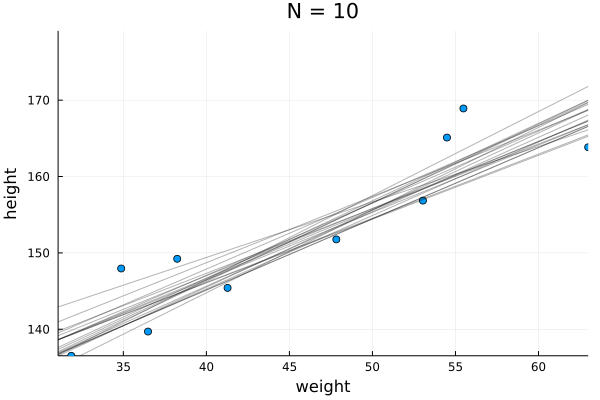

In [223]:
post = sample(mN, 20)
post_df = DataFrame(post);

xlims = extrema(d2.weight)
ylims = extrema(d2.height)
p = @df dN scatter(:weight, :height; xlims=xlims, ylims=ylims)
title!("N = $N"; xlab="weight", ylab="height")

x_mean = mean(dN.weight)
for (a, b) ∈ zip(post_df.a, post_df.b)
    plot!(x -> a + b * (x-x_mean); c="black", alpha=0.3)
end
display(p)

Code 4.50

In [225]:
post = sample(m4_3, 1000)
post_df = DataFrame(post)
μ_at_50 = @. post_df.a + post_df.b * (50 - xbar);

Code 4.51

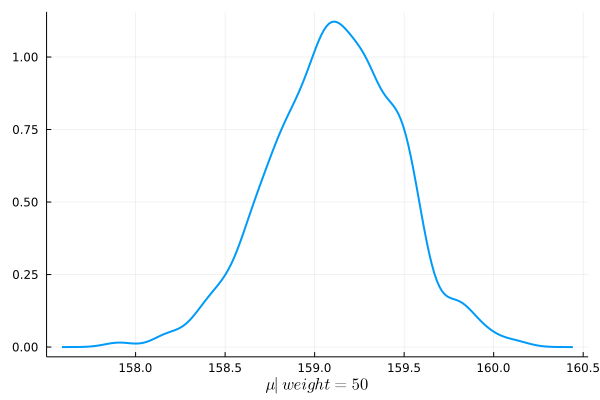

In [228]:
density(μ_at_50; lw=2, xlab=L"\mu|weight=50")

Code 4.52

In [232]:
percentile(μ_at_50, 5), percentile(μ_at_50, 94)

(158.50670674049772, 159.60559710917553)